# Intro to Superresolution

##Stuff to be written

In [193]:
%matplotlib inline
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.lines
from astropy.table import Table, Column
from scipy.optimize import curve_fit
from IPython.display import display, Math, Latex
import scipy.special
from scipy.stats import chisquare
from scipy.stats.mstats import chisquare as cstest

In [2]:
pi, np.pi

(3.141592653589793, 3.141592653589793)

In [3]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.5)

ImportError: No module named 'seaborn'

In [4]:
#sns.set_context()

Imports for the interactive widgets:

In [5]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import display, display_png, display_svg, clear_output
from IPython.core.pylabtools import print_figure

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [93]:
#Define points for later
xdist = arange(-80,80,0.1)
ydist = xdist

#Definitions
xdata = arange(0,5,0.1)

def fexp(x,a,b,c):
    return a*exp(-b*x)+c

def fgau(x,a,b,c):
    return a*exp(-(x-b)**2/(2*c**2))

def fairy(x,a,b,c):
    return a*(scipy.special.jv(1,abs(x-b)*c)/(c*abs(x-b)))**2

def ddata(x,ns):
    noise = ns*randn(len(x))
    return fexp(x,2.5,1.3,0.5) + noise

ydata = ddata(xdata,0.2)

##The principles of localizing single isotropic point sources

Estimating a fluorophore position from an image is, in some sense, an exercise in geometry: without noise, an image of an isotropic light emitter would be a disk (possibly surrounded by diffraction rings) centered on the position of the fluorophore. The position is generally estimated by the center of the point spread function (PSF) of the fluorophore.

The PSF of an imaging system describes the shape of the blur formed when a point source is imaged; it is proportional to the average number of photons at a given position relative to the source. High-accuracy PSF calculations require accounting for numerous factors, particularly the collection angle (numerical aperture) of the lens, interfaces between the sample and lens (such as coverslips and immersion oil) and the dipole moment of the light source.

For an isotropic point source (emitting light equally in all directions), the most common models used in high-precision work are the Richards-Wolf model, which accounts for the vector nature of light waves, and the Gibson-Lanni model, which also accounts for coverslips and other interfaces between the sample and the lens. As long as the lens is well-corrected for aberrations, the general pattern will be a central bright spot whose width corresponds roughly to the wavelength of light. However, although software is available for computing the Richards-Wolf and Gibson-Lanni PSFs (for example, an ImageJ plug-in), the formulas are complicated and are computationally costly. Many investigators therefore approximate the PSF with an Airy function, which is somewhat simpler for mathematical calculations. The Airy PSF is most valid when the lens has a low numerical aperture, but it has sufficient qualitatively validity to be a useful approximation in many investigations

##The Airy PSF formula that dictates the ideal point spread function emmitted from a point dipole source

$$
I(x,y) = \frac{\pi^4}{\epsilon_0^2 n n^\prime} \frac{\mu^2}{\lambda^6} \frac{NA^4}{M^2} \left[ \frac{J_1(2 \pi \tilde{\rho})}{2 \pi \tilde{\rho}} \right]^2, \space \space \tilde{\rho}= \frac{NA (x^2+y^2)}{M \lambda}
$$

where:

$\epsilon_0$ is Permitivity of Free Space

$n$ and $n^\prime$ are the relative Index of Refraction of both the medium and objective respectivetly

$\mu$ is Dipole Moment

$NA$ is the Numerical Aperature Factor that specifies the width of the PSF

$M$ is the Magnification Factor

$\lambda$ is Wavelength of light

$J_1()$ is a Bessel Function of the first kind

$\tilde{\rho}$ is the relative distance away from the PSF center




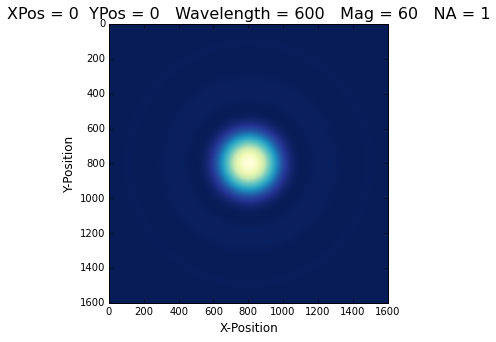

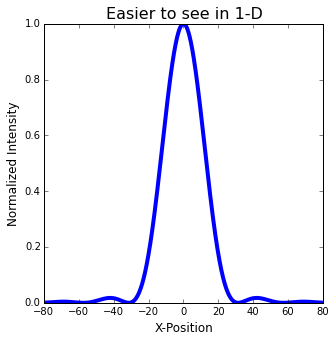

In [143]:
@interact(x_0 =u'0',
          y_0 = u'0',
          l = u'600',
          M = u'60',
          NA = u'1.4')

def plot_airy(x_0=0,
              y_0=0,
              l = 600,
              M = 60,
              NA = 1.4):

    # Define a few parameters for the Airy Function
    
    # Universal Constants
    epsilon_0 = 1 # Permitivity of Free Space (assuming atomic units)
    
    # Experimental Constants
    mu = 1        # Dipole Moment (dependent on which dye is used)
    #NA = 1.4      # Numerical Aperature
    #l  = 600      # Wavelength in nm
    n  = 1.518    #index of refraction of material surrounding emmitter
    n_prime = 1.518 #index of refraction of objective
    #M  = 60       # Magnification (60x)
    
    #Jury rigging the code
    x_0 = np.float(x_0)
    y_0 = np.float(y_0)
    l = np.float(l)
    M = np.float(M)
    NA = np.float(NA)
    
    # Function
    xx, yy = meshgrid(xdist, ydist, sparse=True) # Prepares Grid Points
    rho = np.sqrt((xx-x_0)**2+(yy-y_0)**2) # Distance from center
    rho_tilde = 500*rho*NA/(M*l) # The 500 is just a scaling factor
    
    I = (2*scipy.special.jv(1,2*math.pi*rho_tilde)/(2*math.pi*rho_tilde))**2 #Represents where we recieve the photons spatially

    
    # Plot the graphs!
    figure(1)
    plt.figure(figsize=(5,5))
    imshow(I, cmap='YlGnBu_r', interpolation='nearest');
    title('XPos = %d  YPos = %d   Wavelength = %d   Mag = %d   NA = %d' % (x_0, y_0, l, M, NA),
          fontsize=16)
    xlabel('X-Position', fontsize=12)
    ylabel('Y-Position', fontsize=12)

    figure(2)
    plt.figure(figsize=(5,5))
    plot(xdist,I[I.shape[1]/2+y_0/0.1,:], lw= 4);
    title(r"Easier to see in 1-D",
          fontsize=16)
    xlabel('X-Position', fontsize=12)
    ylabel('Normalized Intensity', fontsize=12)

Check colormaps here: http://matplotlib.org/users/colormaps.html

##Fit Gaussian to our Airy Function

Even the Airy PSF is still tedious for many practical
calculations. Consequently, people often approximate the PSF of
an isotropic source with a Gaussian function:

$$
I(x,y) = I_0*exp(-NA*k^2((x-x_0)^2+(y-y_0)^2))+b
$$

where:

$k$ is $2\pi$ divided by the wavelength of light in the sample

$NA$ is the Numerical Aperature Factor that specifies the width of the PSF

$x_0$ and $y_0$ are the center of the Gaussian PSF

##So how good of a fit is this Gaussian Function?


Normalization      FWHM           Center      
------------- ------------- ------------------
 1.0172833921 46.4296620097 -5.83711090089e-06

  Norm std dev    FWHM std dev   Center std dev
--------------- --------------- ---------------
0.0010884716336 0.0133655669227 0.0133171002564

Gau fit parameters      1.017 -0.000 10.818
Gau fit std dev         0.001  0.013  0.013

Chi Squared Goodnes of Fit Test
     Xv      PValue
------------ ------
0.5138983249    1.0


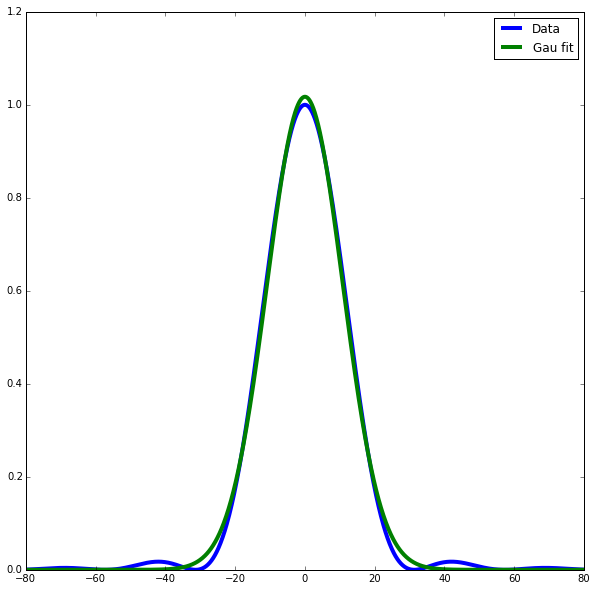

In [203]:
@interact(x_0 = u'0',
          l = u'600',
          M = u'60',
          NA = u'1.4')
def plot_airy2d(x_0=0, l = 600, M = 60, NA = 1.4):

    # Define a few parameters for the Airy Function
    
    # Universal Constants
    epsilon_0 = 1 # Permitivity of Free Space (assuming atomic units)
    
    # Experimental Constants
    mu = 1        # Dipole Moment (dependent on which dye is used)
    #NA = 1.4      # Numerical Aperature
    #l  = 600      # Wavelength in nm
    n  = 1.518    #index of refraction of material surrounding emmitter
    n_prime = 1.518 #index of refraction of objective
    #M  = 60       # Magnification (60x)
          
    #Jury rigging the code
    x_0 = np.float(x_0)
    l = np.float(l)
    M = np.float(M)
    NA = np.float(NA)
    
    # Function
    xx, yy = meshgrid(xdist, ydist, sparse=True) # Prepares Grid Points
    rho = np.sqrt((xx-x_0)**2+(yy)**2) # Distance from center
    rho_tilde = 500*rho*NA/(M*l) # The 500 is just a scaling factor
          
    #I_0 = (math.pi**4/(epsilon_0*n*n_prime))*(mu**2/l**6)*(NA**4/M**2)  # Represents the number of photons we recieve
    
    I = (2*scipy.special.jv(1,2*math.pi*rho_tilde)/(2*math.pi*rho_tilde))**2 #Represents where we recieve the photons spatially
    

    pg,cg = curve_fit(fgau,xdist,I[I.shape[1]/2,:])
    
    ygau = fgau(xdist,*pg)
    
    #Calculating Chi^2
    data = I[I.shape[1]/2,:]
    expected_values=scipy.array(data)
    observed_values=scipy.array(ygau)
    Xmin,pvalue = chisquare(observed_values, f_exp=expected_values,ddof=3)
    pvalue = np.float(pvalue)
    Xmin = np.float(Xmin)
    Xv = Xmin/(xdist.shape[0]-3)
    #chi = np.array([Xv,pvalue])
    
    
    plt.figure(figsize=(10,10))
    plot(xdist,I[I.shape[1]/2,:],'b-',label='Data',lw= 4)

    plot(xdist,ygau,'g-',label='Gau fit', lw= 4)
    legend()
    print('')
    t = Table()
    t['Normalization'] = [pg[0]]
    t['FWHM'] = [2.0*math.sqrt(2.0*math.log(10.0))*pg[2]]
    t['Center'] = [pg[1]]
    print(t)
    
    print('')

    tstddev = Table()
    tstddev['Norm std dev'] = [sqrt(diag(cg))[0]]
    tstddev['FWHM std dev'] = [sqrt(diag(cg))[2]]
    tstddev['Center std dev'] = [sqrt(diag(cg))[1]]
    print(tstddev)
    
    print('')
    
    print('Gau fit parameters     {0:6.3f} {1:6.3f} {2:6.3f}'.format(*pg))
    print('Gau fit std dev        {0:6.3f} {1:6.3f} {2:6.3f}'.format(*sqrt(diag(cg))))
    
    print('')
    print('Chi Squared Goodnes of Fit Test')
    chitable = Table()
    chitable['Xv'] = [Xv]
    chitable['PValue'] = [pvalue]
    print(chitable)

Indeed, almost any realistic PSF will look roughly similar to a Gaussian bell curve near the peak of a focused image which is the main reason why the Gaussian approximation gives useful and reasonably accurate results in many investigations involving focused images of fluorophores

But in reality, experiments cannot obtain this detailed resolution of the PSF. We are limited by the tools that we use. In our example of a collecting photons from a point dipole source, we are limited in our spatial resolution by our pixels. This implementation issue is called "pixelation". The signal on a pixel is the sum of the photons striking different parts of it, which is proportional to the integral of the PSF over the pixel area.

If the size of the pixel is substantially smaller than the PSF width (a fraction of a wavelength in the object plane, for a typical diffraction-limited PSF), the signal can usually be approximated with the PSF value at the center of the pixel. However, if the pixel is larger, or if high precision is required, the integral of the PSF over the pixel area must be used (for example, an error function for the Gaussian PSF)

Pixel = 2,4,5,8,10,16,20,25,32,40,50,64,80,100,160,200,320,400,800,1600


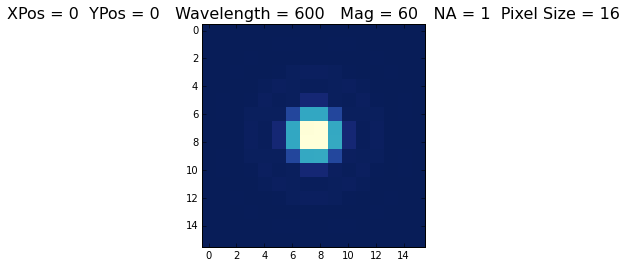

In [68]:
@interact(x_0 = u'0',
          y_0 = u'0',
          l = u'600',
          M = u'60',
          NA = u'1.4', 
          pixelsize = u'16')
def plot_airy(x_0=0, y_0=0, l = 600, M = 60, NA = 1.4,pixelsize = 16):

    # Define a few parameters for the Airy Function
    
    # Universal Constants
    epsilon_0 = 1 # Permitivity of Free Space (assuming atomic units)
    
    # Experimental Constants
    mu = 1        # Dipole Moment (dependent on which dye is used)
    #NA = 1.4      # Numerical Aperature
    #l  = 600      # Wavelength in nm
    n  = 1.518    #index of refraction of material surrounding emmitter
    n_prime = 1.518 #index of refraction of objective
    #M  = 60       # Magnification (60x)
    
    #Jury rigging the code
    x_0 = np.float(x_0)
    y_0 = np.float(y_0)
    l = np.float(l)
    M = np.float(M)
    NA = np.float(NA)
    pixelsize = np.float(pixelsize)
    
    # Function
    xx, yy = meshgrid(xdist, ydist, sparse=True) # Prepares Grid Points
    rho = np.sqrt((xx-x_0)**2+(yy-y_0)**2) # Distance from center
    rho_tilde = 500*rho*NA/(M*l) # The 500 is just a scaling factor
    
    #Usable Pixel Numbers
    print('Pixel = 2,4,5,8,10,16,20,25,32,40,50,64,80,100,160,200,320,400,800,1600')
    
    #I_0 = (math.pi**4/(epsilon_0*n*n_prime))*(mu**2/l**6)*(NA**4/M**2)  # Represents the number of photons we recieve
    
    I = (2*scipy.special.jv(1,2*math.pi*rho_tilde)/(2*math.pi*rho_tilde))**2 #Represents where we recieve the photons spatially
    
    pixel = I.reshape(pixelsize,1600/pixelsize,pixelsize,1600/pixelsize)
    pixel = pixel.sum(axis=3).sum(axis=1)
    xpixel = linspace(-80,80,16)
    ypixel = xpixel
    centerpixel = xpixel-5
    barsize = 9
    
    figure(1)
    plt.figure(figsize=(10,10))
    imshow(pixel,cmap='YlGnBu_r',interpolation = 'nearest')
    title('XPos = %d  YPos = %d   Wavelength = %d   Mag = %d   NA = %d  Pixel Size = %d' %
          (x_0, y_0, l, M, NA, pixelsize),
          fontsize = 16)

##Now for 1-D:

Pixel = 2,4,5,8,10,16,20,25,32,40,50,64,80,100,160,200,320,400,800,1600


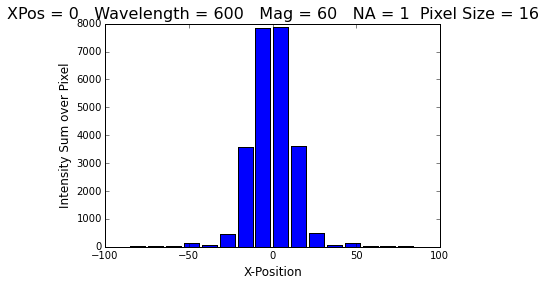

In [72]:
@interact(x_0 = u'0',
          l = u'600',
          M = u'60',
          NA = u'1.4',
          pixelsize = u'16')
def plot_airy2d(x_0=0, l = 600, M = 60, NA = 1.4, pixelsize = 16):

    # Define a few parameters for the Airy Function
    
    # Universal Constants
    epsilon_0 = 1 # Permitivity of Free Space (assuming atomic units)
    
    # Experimental Constants
    mu = 1        # Dipole Moment (dependent on which dye is used)
    #NA = 1.4      # Numerical Aperature
    #l  = 600      # Wavelength in nm
    n  = 1.518    #index of refraction of material surrounding emmitter
    n_prime = 1.518 #index of refraction of objective
    #M  = 60       # Magnification (60x)
    
    #Jury rigging the code
    x_0 = np.float(x_0)
    l = np.float(l)
    M = np.float(M)
    NA = np.float(NA)
    pixelsize = np.float(pixelsize)
    
    #Usable Pixel Numbers
    print('Pixel = 2,4,5,8,10,16,20,25,32,40,50,64,80,100,160,200,320,400,800,1600')
    
    # Function
    xx, yy = meshgrid(xdist, ydist, sparse=True) # Prepares Grid Points
    rho = np.sqrt((xx-x_0)**2+(yy)**2) # Distance from center
    rho_tilde = 500*rho*NA/(M*l) # The 500 is just a scaling factor
    
    #I_0 = (math.pi**4/(epsilon_0*n*n_prime))*(mu**2/l**6)*(NA**4/M**2)  # Represents the number of photons we recieve
    
    I = (2*scipy.special.jv(1,2*math.pi*rho_tilde)/(2*math.pi*rho_tilde))**2 #Represents where we recieve the photons spatially
    
    pixel = I.reshape(pixelsize,1600/pixelsize,pixelsize,1600/pixelsize)
    pixel = pixel.sum(axis=3).sum(axis=1)
    xpixel = linspace(-80,80,pixelsize)
    ypixel = xpixel
    centerpixel = xpixel-5
    barwidth= 144/pixelsize
    plt.figure(figsize=(10,10))
    bar(centerpixel,pixel[pixel.shape[1]/2,:],width=barwidth)
    title('XPos = %d   Wavelength = %d   Mag = %d   NA = %d  Pixel Size = %d' %
          (x_0, l, M, NA, pixelsize),
          fontsize = 16)
    xlabel('X-Position', fontsize=12)
    ylabel('Intensity Sum over Pixel', fontsize=12)

In [233]:
@interact(x_0 =u'0',
          l = u'600',
          M = u'60',
          NA = u'1.4',
          pixelsize = u'16')

def plot_airy2d(x_0=0,
                l = 600,
                M = 60,
                NA = 1.4,
                pixelsize = 16):

    # Define a few parameters for the Airy Function
    
    # Universal Constants
    epsilon_0 = 1 # Permitivity of Free Space (assuming atomic units)
    
    # Experimental Constants
    mu = 1        # Dipole Moment (dependent on which dye is used)
    #NA = 1.4      # Numerical Aperature
    #l  = 600      # Wavelength in nm
    n  = 1.518    #index of refraction of material surrounding emmitter
    n_prime = 1.518 #index of refraction of objective
    #M  = 60       # Magnification (60x)
    
    #Jury rigging the code
    x_0 = np.float(x_0)
    l = np.float(l)
    M = np.float(M)
    NA = np.float(NA)
    pixelsize = np.float(pixelsize)
    
    #Usable Pixel Numbers
    print('Pixel = 2,4,5,8,10,16,20,25,32,40,50,64,80,100,160,200,320,400,800,1600')
    
    # Function
    xx, yy = meshgrid(xdist, ydist, sparse=True) # Prepares Grid Points
    rho = np.sqrt((xx-x_0)**2+(yy)**2) # Distance from center
    rho_tilde = 500*rho*NA/(M*l) # The 500 is just a scaling factor
    
    #I_0 = (math.pi**4/(epsilon_0*n*n_prime))*(mu**2/l**6)*(NA**4/M**2)  # Represents the number of photons we recieve
    
    I = (2*scipy.special.jv(1,2*math.pi*rho_tilde)/(2*math.pi*rho_tilde))**2 #Represents where we recieve the photons spatially
    
    pixel = I.reshape(pixelsize,1600/pixelsize,pixelsize,1600/pixelsize)
    pixel = pixel.sum(axis=3).sum(axis=1)
    pixel = pixel/8000
    xpixel = linspace(-80,80,pixelsize)
    centerpixel = xpixel-5
    barwidth= 144/pixelsize
    
    pg,cg = curve_fit(fgau,xpixel,pixel[pixel.shape[1]/2,:],p0=[1,x_0,5])
    pga,cga = curve_fit(fairy,xpixel,pixel[pixel.shape[1]/2,:],p0=[1,x_0,1])
    
    ygau = fgau(xdist,*pg)
    pygau = fgau(xpixel,*pg)
    yairy = fairy(xdist,*pga)
    pyairy = fairy(xpixel,*pg)
    
    #Calculating Chi^2
    data = pixel[pixel.shape[1]/2,:]
    #datsize = (xpixel.size[1]-3)
    datsize=10
    expected_values=scipy.array(data)
    observed_valuesg=scipy.array(pygau)
    observed_valuesa=scipy.array(pyairy)
    Xming,pvalueg = chisquare(observed_valuesg, f_exp=expected_values, ddof=3)
    Xmina,pvaluea = chisquare(observed_valuesa, f_exp=expected_values, ddof=3)
    Xming = np.float(Xming)
    Xvg = Xming/datsize
    Xmina = np.float(Xmina)
    Xva = Xmina/datsize
    pvalueg = np.float(pvalueg)
    pvaluea = np.float(pvaluea)
    
    
    #Plotting
    plt.figure(figsize=(10,10))
    bar(centerpixel,pixel[pixel.shape[1]/2,:],width=barwidth,label='Data')
    #plot(xdist,I[I.shape[1]/2,:],'b-',label='Data')
    
    plot(xdist,ygau,'g-',label='Gau fit',lw= 4)
    plot(xdist,yairy,'k-',label='Airy fit',lw= 4)
    plot(xpixel,pygau,'ro')
    title('XPos = %d   Wavelength = %d   Mag = %d   NA = %d  Pixel Size = %d' %
          (x_0, l, M, NA, pixelsize),
          fontsize = 16)
    xlabel('X-Position', fontsize=12)
    ylabel('Sum Intensity over Pixel', fontsize=12)
    legend()
    
    print('')
    print('Gaussian')
    print('')
    t = Table()
    t['Normalization'] = [pg[0]]
    t['FWHM'] = [2.0*math.sqrt(2.0*math.log(10.0))*pg[2]]
    t['Center'] = [pg[1]]
    print(t)
    
    print('')
    tstddev = Table()
    tstddev['Norm std dev'] = [sqrt(diag(cg))[0]]
    tstddev['FWHM std dev'] = [sqrt(diag(cg))[2]]
    tstddev['Center std dev'] = [sqrt(diag(cg))[1]]
    print(tstddev)
    
    print('')
    print('Airy')
    print('')
    ta = Table()
    ta['Normalization']=[pga[0]]
    #ta['FWHM'] = [pga[2]]
    ta['Center'] = [pga[1]]
    print(ta)
    
    print('')
    tstddev = Table()
    tstddev['Norm std dev'] = [sqrt(diag(cga))[0]]
    #tstddev['FWHM std dev'] = [sqrt(diag(cga))[2]]
    tstddev['Center std dev'] = [sqrt(diag(cga))[1]]
    print(tstddev)
   
    
    print('')
    
    print('Gau fit parameters     {0:6.3f} {1:6.3f} {2:6.3f}'.format(*pg))
    print('Gau fit std dev        {0:6.3f} {1:6.3f} {2:6.3f}'.format(*sqrt(diag(cg))))
    
    print('')
    print('Chi Squared Goodnes of Fit Test')
    chitable = Table()
    chitable['Xv'] = [Xvg]
    chitable['PValue'] = [pvalueg]
    print(chitable)
    
    print('Airy fit parameters     {0:6.3f} {1:6.3f} {2:6.3f}'.format(*pga))
    print('Airy fit std dev        {0:6.3f} {1:6.3f} {2:6.3f}'.format(*sqrt(diag(cga))))
    print('')
    print('Chi Squared Goodnes of Fit Test')
    chitable = Table()
    chitable['Xv'] = [Xva]
    chitable['PValue'] = [pvaluea]
    print(chitable)
    

Pixel = 2,4,5,8,10,16,20,25,32,40,50,64,80,100,160,200,320,400,800,1600


TypeError: unsupported operand type(s) for -: 'Normalize' and 'Normalize'

##Noise

Unfortunately, this is still very ideal. There can be noise in our system from other sources (autoflourecense, scattering, or  photons from a nearby lightsource leaking into our sample box. For now, we will simply the problem by looking at a single image in a movie.

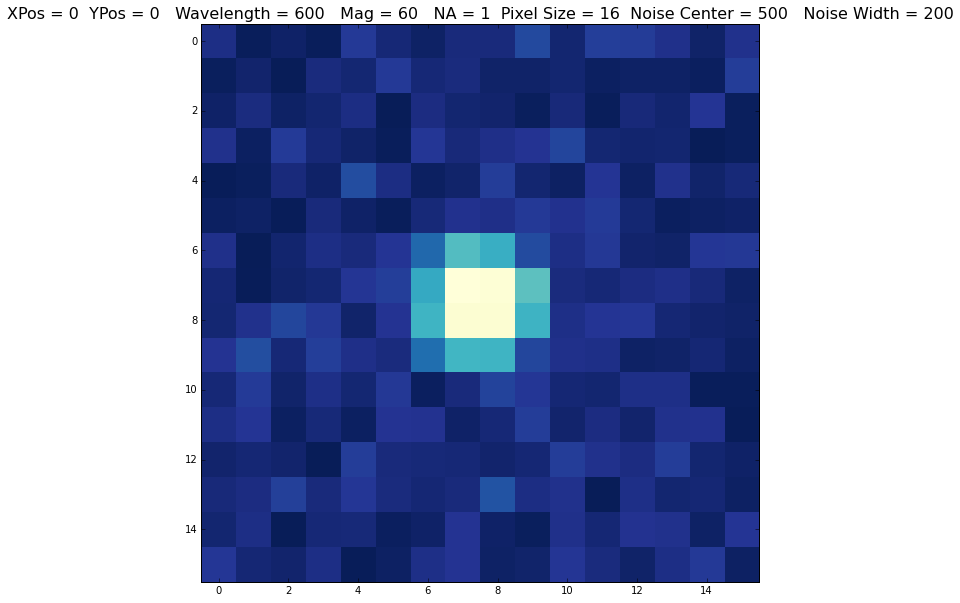

In [124]:
@interact(x_0 = u'0',
          y_0 = u'0',
          l = u'600',
          M = u'60', 
          NA = u'1.4',
          pixelsize = u'16',
          NoiseCenter = u'500',
          NoiseWidth = u'200')

def plot_airy2d(x_0 = 0,
                y_0 = 0,
                l = 600,
                M = 60,
                NA = 1.4,
                pixelsize = 16,
                NoiseCenter = 500,
                NoiseWidth = 200):

    # Define a few parameters for the Airy Function
    
    # Universal Constants
    epsilon_0 = 1 # Permitivity of Free Space (assuming atomic units)
    
    # Experimental Constants
    mu = 1        # Dipole Moment (dependent on which dye is used)
    #NA = 1.4      # Numerical Aperature
    #l  = 600      # Wavelength in nm
    n  = 1.518    #index of refraction of material surrounding emmitter
    n_prime = 1.518 #index of refraction of objective
    #M  = 60       # Magnification (60x)
    
    #Jury rigging the code
    x_0 = np.float(x_0)
    y_0 = np.float(y_0)
    l = np.float(l)
    M = np.float(M)
    NA = np.float(NA)
    pixelsize = np.float(pixelsize)
    NoiseCenter = np.float(NoiseCenter)
    NoiseWidth = np.float(NoiseWidth)
    
    # Function
    xx, yy = meshgrid(xdist, ydist, sparse=True) # Prepares Grid Points
    rho = np.sqrt((xx-x_0)**2+(yy-y_0)**2) # Distance from center
    rho_tilde = 500*rho*NA/(M*l) # The 500 is just a scaling factor
    
    #I_0 = (math.pi**4/(epsilon_0*n*n_prime))*(mu**2/l**6)*(NA**4/M**2)  # Represents the number of photons we recieve
    
    I = (2*scipy.special.jv(1,2*math.pi*rho_tilde)/(2*math.pi*rho_tilde))**2 #Represents where we recieve the photons spatially
    
    pixel = I.reshape(pixelsize,1600/pixelsize,pixelsize,1600/pixelsize)
    pixel = pixel.sum(axis=3).sum(axis=1)
    xpixel = linspace(-80,80,16)
    centerpixel = xpixel-5

    noise = np.random.normal(loc=500.0,scale=500.0,size=(16,16))
    pixelnoise = pixel + abs(noise)
    plt.figure(figsize=(10,10))
    imshow(pixelnoise,cmap='YlGnBu_r',interpolation = 'nearest')
    title('XPos = %d  YPos = %d   Wavelength = %d   Mag = %d   NA = %d  Pixel Size = %d  Noise Center = %d   Noise Width = %d' %
          (x_0, y_0, l, M, NA, pixelsize, NoiseCenter, NoiseWidth),
          fontsize = 16)

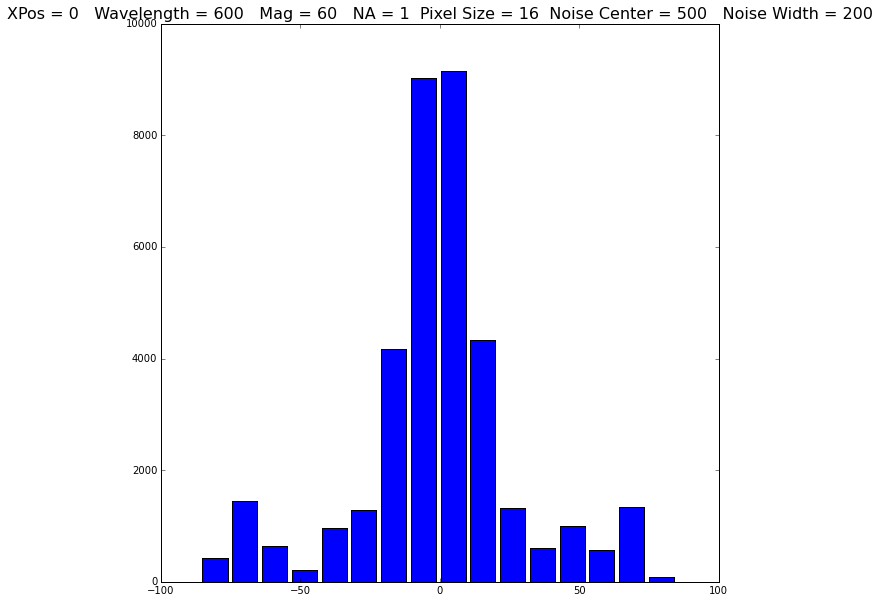

In [132]:
@interact(x_0 =u'0',
          l = u'600',
          M = u'60', 
          NA = u'1.4',
          pixelsize = u'16',
          NoiseCenter = u'500',
          NoiseWidth = u'200')

def plot_airy2d(x_0=0,
                l = 600,
                M = 60,
                NA = 1.4,
                pixelsize = 16,
                NoiseCenter = 500,
                NoiseWidth = 200):

    # Define a few parameters for the Airy Function
    
    # Universal Constants
    epsilon_0 = 1 # Permitivity of Free Space (assuming atomic units)
    
    # Experimental Constants
    mu = 1        # Dipole Moment (dependent on which dye is used)
    #NA = 1.4      # Numerical Aperature
    #l  = 600      # Wavelength in nm
    n  = 1.518    #index of refraction of material surrounding emmitter
    n_prime = 1.518 #index of refraction of objective
    #M  = 60       # Magnification (60x)
    
    #Jury rigging the code
    x_0 = np.float(x_0)
    l = np.float(l)
    M = np.float(M)
    NA = np.float(NA)
    pixelsize = np.float(pixelsize)
    NoiseCenter = np.float(NoiseCenter)
    NoiseWidth = np.float(NoiseWidth)
    
    # Function
    xx, yy = meshgrid(xdist, ydist, sparse=True) # Prepares Grid Points
    rho = np.sqrt((xx-x_0)**2+(yy)**2) # Distance from center
    rho_tilde = 500*rho*NA/(M*l) # The 500 is just a scaling factor
    
    #I_0 = (math.pi**4/(epsilon_0*n*n_prime))*(mu**2/l**6)*(NA**4/M**2)  # Represents the number of photons we recieve
    
    I = (2*scipy.special.jv(1,2*math.pi*rho_tilde)/(2*math.pi*rho_tilde))**2 #Represents where we recieve the photons spatially
    
    pixel = I.reshape(pixelsize,1600/pixelsize,pixelsize,1600/pixelsize)
    pixel = pixel.sum(axis=3).sum(axis=1)
    xpixel = linspace(-80,80,16)
    centerpixel = xpixel-5
    barwidth= 144/pixelsize

    noise = np.random.normal(loc=500.0,scale=500.0,size=(16,16))
    pixelnoise = pixel + abs(noise)
    
    plt.figure(figsize=(10,10))
    bar(centerpixel,pixelnoise[pixelnoise.shape[1]/2,:],width=)
    title('XPos = %d   Wavelength = %d   Mag = %d   NA = %d  Pixel Size = %d  Noise Center = %d   Noise Width = %d' %
          (x_0, l, M, NA, pixelsize, NoiseCenter, NoiseWidth),
          fontsize = 16)


Gaussian

Normalization     FWHM         Center    
------------- ------------ --------------
9136.57182945 51.450353012 0.064767138022

 Norm std dev  FWHM std dev  Center std dev
------------- -------------- --------------
528.878818387 0.801767183169 0.800882991254

Airy

Normalization       Center     
------------- -----------------
36237.1044988 -0.00387944899267

 Norm std dev Center std dev
------------- --------------
1910.69472727  0.73591644171

Gau fit parameters     9136.572  0.065 11.988
Gau fit std dev        528.879  0.801  0.802
Airy fit parameters     36237.104 -0.004 -0.112
Airy fit std dev        1910.695  0.736  0.006


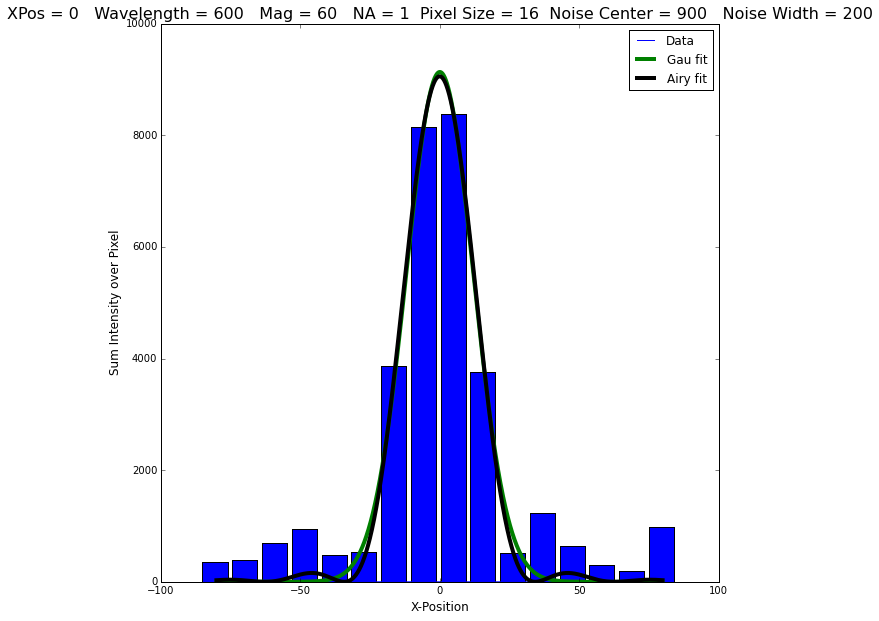

In [151]:
@interact(x_0 =u'0',
          l = u'600',
          M = u'60', 
          NA = u'1.4',
          pixelsize = u'16',
          NoiseCenter = u'500',
          NoiseWidth = u'200')

def plot_airy2d(x_0=0,
                l = 600,
                M = 60,
                NA = 1.4,
                pixelsize = 16,
                NoiseCenter = 500,
                NoiseWidth = 200):
    # Define a few parameters for the Airy Function
    
    # Universal Constants
    epsilon_0 = 1 # Permitivity of Free Space (assuming atomic units)
    
    # Experimental Constants
    mu = 1        # Dipole Moment (dependent on which dye is used)
    #NA = 1.4      # Numerical Aperature
    #l  = 600      # Wavelength in nm
    n  = 1.518    #index of refraction of material surrounding emmitter
    n_prime = 1.518 #index of refraction of objective
    #M  = 60       # Magnification (60x)
    
    #Jury rigging the code
    x_0 = np.float(x_0)
    l = np.float(l)
    M = np.float(M)
    NA = np.float(NA)
    pixelsize = np.float(pixelsize)
    NoiseCenter = np.float(NoiseCenter)
    NoiseWidth = np.float(NoiseWidth)
    
    # Function
    xx, yy = meshgrid(xdist, ydist, sparse=True) # Prepares Grid Points
    rho = np.sqrt((xx-x_0)**2+(yy)**2) # Distance from center
    rho_tilde = 500*rho*NA/(M*l) # The 500 is just a scaling factor
    
    #I_0 = (math.pi**4/(epsilon_0*n*n_prime))*(mu**2/l**6)*(NA**4/M**2)  # Represents the number of photons we recieve
    
    I = (2*scipy.special.jv(1,2*math.pi*rho_tilde)/(2*math.pi*rho_tilde))**2 #Represents where we recieve the photons spatially
    
    pixel = I.reshape(16,100,16,100)
    pixel = pixel.sum(axis=3).sum(axis=1)
    xpixel = linspace(-80,80,16)
    centerpixel = xpixel-5
    barwidth= 144/pixelsize
    
    noise = np.random.normal(loc=500.0,scale=500.0,size=(16,16))
    pixelnoise = pixel + abs(noise)
    
    pg,cg = curve_fit(fgau,xpixel,pixelnoise[pixelnoise.shape[1]/2,:])
    pga,cga = curve_fit(fairy,xpixel,pixelnoise[pixelnoise.shape[1]/2,:],p0=[8000,x_0,1])
    
    ygau = fgau(xdist,*pg)
    yairy = fairy(xdist,*pga)
    
    plt.figure(figsize=(10,10))
    bar(centerpixel,pixelnoise[pixelnoise.shape[1]/2,:],width=barwidth)
    plot(xdist,I[I.shape[1]/2,:],'b-',label='Data')
    
    plot(xdist,ygau,'g-',label='Gau fit',lw= 4)
    plot(xdist,yairy,'k-',label='Airy fit',lw= 4)
    title('XPos = %d   Wavelength = %d   Mag = %d   NA = %d  Pixel Size = %d  Noise Center = %d   Noise Width = %d' %
          (x_0, l, M, NA, pixelsize, NoiseCenter, NoiseWidth),
          fontsize = 16)
    xlabel('X-Position', fontsize=12)
    ylabel('Sum Intensity over Pixel', fontsize=12)
    legend()
    
    print('')
    print('Gaussian')
    print('')
    t = Table()
    t['Normalization'] = [pg[0]]
    t['FWHM'] = [2.0*math.sqrt(2.0*math.log(10.0))*pg[2]]
    t['Center'] = [pg[1]]
    print(t)
    
    print('')
    tstddev = Table()
    tstddev['Norm std dev'] = [sqrt(diag(cg))[0]]
    tstddev['FWHM std dev'] = [sqrt(diag(cg))[2]]
    tstddev['Center std dev'] = [sqrt(diag(cg))[1]]
    print(tstddev)
    
    print('')
    print('Airy')
    print('')
    ta = Table()
    ta['Normalization']=[pga[0]]
    #ta['FWHM'] = [pga[2]]
    ta['Center'] = [pga[1]]
    print(ta)
    
    print('')
    tstddev = Table()
    tstddev['Norm std dev'] = [sqrt(diag(cga))[0]]
    #tstddev['FWHM std dev'] = [sqrt(diag(cga))[2]]
    tstddev['Center std dev'] = [sqrt(diag(cga))[1]]
    print(tstddev)
   
    
    print('')
    
    print('Gau fit parameters     {0:6.3f} {1:6.3f} {2:6.3f}'.format(*pg))
    print('Gau fit std dev        {0:6.3f} {1:6.3f} {2:6.3f}'.format(*sqrt(diag(cg))))
    print('Airy fit parameters     {0:6.3f} {1:6.3f} {2:6.3f}'.format(*pga))
    print('Airy fit std dev        {0:6.3f} {1:6.3f} {2:6.3f}'.format(*sqrt(diag(cga))))
    

#Finding Standard Deviation of Center

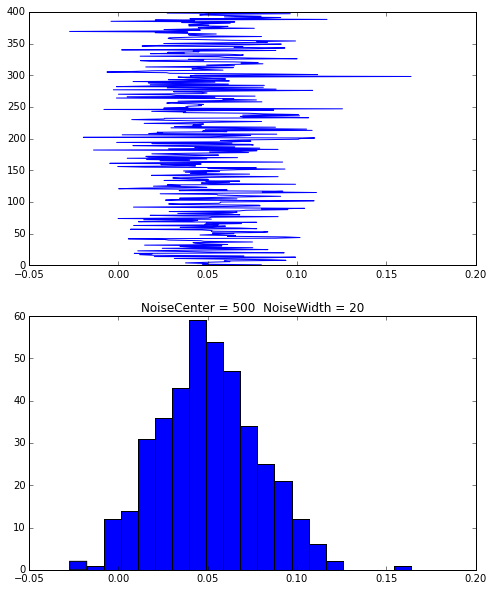

In [30]:
@interact(x_0 = u'0',
          l = u'600',
          M = u'60',
          NA = u'1.4',
          NoiseCenter = u'500',
          NoiseWidth = u'200')
def plot_noise(x_0 = 0, l = 600, M = 60, NA = 1.4, NoiseCenter=500.0, NoiseWidth=200.0):
    
    
    # Define a few parameters for the Airy Function
    
    # Universal Constants
    epsilon_0 = 1 # Permitivity of Free Space (assuming atomic units)
    
    # Experimental Constants
    mu = 1        # Dipole Moment (dependent on which dye is used)
    #NA = 1.4      # Numerical Aperature
    #l  = 600      # Wavelength in nm
    n  = 1.518    #index of refraction of material surrounding emmitter
    n_prime = 1.518 #index of refraction of objective
    #M  = 60       # Magnification (60x)
    
    #Jury rigging the code
    x_0 = np.float(x_0)
    l = np.float(l)
    M = np.float(M)
    NA = np.float(NA)
    NoiseCenter = np.float(NoiseCenter)
    NoiseWidth = np.float(NoiseWidth)
    
    # Function
    xx, yy = meshgrid(xdist, ydist, sparse=True) # Prepares Grid Points
    rho = np.sqrt((xx-x_0)**2+(yy)**2) # Distance from center
    rho_tilde = 500*rho*NA/(M*l) # The 500 is just a scaling factor
    
    #I_0 = (math.pi**4/(epsilon_0*n*n_prime))*(mu**2/l**6)*(NA**4/M**2)  # Represents the number of photons we recieve
    
    I = (2*scipy.special.jv(1,2*math.pi*rho_tilde)/(2*math.pi*rho_tilde))**2 #Represents where we recieve the photons spatially
    
    pixel = I.reshape(16,100,16,100)
    pixel = pixel.sum(axis=3).sum(axis=1)
    xpixel = linspace(-80,80,16)
    centerpixel = xpixel-5
    
    sample = 400
    Average = 1
    
    noise_all = np.random.normal(loc=NoiseCenter, scale=NoiseWidth, size=(sample, 16, 16))
    pos = np.zeros(shape=(sample))
    for n in range(0, sample):
        noise = noise_all[n]
        pixelnoise = pixel + abs(noise)
        pg,cg = curve_fit(fgau,xpixel,pixelnoise[pixelnoise.shape[1]/2,:])
        pos[n]=pg[1]

    poshist, posedge = histogram(pos,20)

    plt.figure(1,figsize=(8, 10))
    plt.subplot(211)
    plt.plot(pos,range(0,sample))

    plt.subplot(212)
    plt.hist(pos,20)
    plt.title('NoiseCenter = %d  NoiseWidth = %d' % (NoiseCenter, NoiseWidth))
    
    # Hack that may not be needed anymore
    #fig = gcf()
    #plt.close()
    #display(fig)

See also: http://stackoverflow.com/questions/24961674/ipython-notebook-widgets-for-matplotlib-interactivity

In [15]:
#%load_ext line_profiler

In [16]:
#%lprun -f plot_noise plot_noise()

In [17]:
sample = 10000
Average = 1
NoiseCenter = 500.0
NoiseWidth = 200.0

pos = np.zeros(shape=(sample))
for n in range(0,sample):
    noise = np.random.normal(loc=NoiseCenter,scale=NoiseWidth,size=(16,16))
    pixelnoise = pixel + abs(noise)
    pg,cg = curve_fit(fgau,xpixel,pixelnoise[pixelnoise.shape[1]/2,:])
    pos[n]=pg[1]


poshist, posedge = histogram(pos,20)
# TO FINISH AVERAGING LATER
#pixel = I.reshape(16,100,16,100)
#pixel = pixel.sum(axis=3).sum(axis=1)
#xpixel = linspace(-80,80,16)

NameError: name 'pixel' is not defined

In [ ]:
#plt.figure(1,figsize=(8, 20))
#plt.subplot(211)
#plt.plot(pos,range(0,sample))
#
#plt.subplot(212)
#plt.hist(pos,20)
#plt.show()

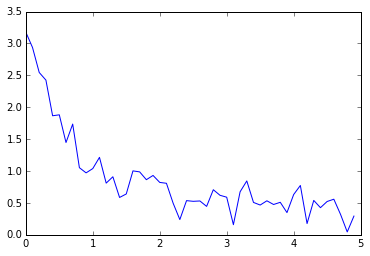

In [38]:
plot(xdata,ydata)

Fit data to exp and gau curves

In [66]:
pe,ce = curve_fit(fexp,xdata,ydata)
pg,cg = curve_fit(fgau,xdata,ydata)
yexp = fexp(xdata,*pe)
ygau = fgau(xdata,*pg)
    
plot(xdata,ydata,'-sb',ls=':',label='Data')

plot(xdata,yexp,'r-',label='Exp fit')
plot(xdata,ygau,'g-',label='Gau fit')
legend()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Print Fit Parameters

In [40]:
print 'Exp fit params         {0:6.3f} {1:6.3f} {2:6.3f}'.format(*pe)
print 'Exp fit std dev        {0:6.3f} {1:6.3f} {2:6.3f}'.format(*sqrt(diag(ce)))
print 'Gau fit parameters     {0:6.3f} {1:6.3f} {2:6.3f}'.format(*pg)
print 'Gau fit std dev        {0:6.3f} {1:6.3f} {2:6.3f}'.format(*sqrt(diag(cg)))

Exp fit params          2.751  1.460  0.478
Exp fit std dev         0.128  0.129  0.040


NameError: name 'pg' is not defined

In [40]:
x = [1,2]
x

[1, 2]

In [188]:
from scipy.stats import chisquare
 
observed_values=scipy.array([18,21,16,7,15])
expected_values=scipy.array([22,19,44,8,16])
 
a,b = chisquare(observed_values, f_exp=expected_values)
a

18.943480861244019

In [231]:
normalize?

In [235]:
chisquare?